### Conll 2003 evaluation

Data downloaded from [here](https://github.com/kyzhouhzau/BERT-NER/tree/master/NERdata).

In [53]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import warnings
import os
import sys

sys.path.append("../")

warnings.filterwarnings("ignore")

In [54]:
data_path = "/home/ec2-user/datadrive/conll-2003/"

train_path = data_path + "train.txt"
dev_path = data_path + "dev.txt"
test_path = data_path + "test.txt"

### 0. Prc data for csv format

In [55]:
import codecs


def read_data(input_file):
    """Reads a BIO data."""
    with codecs.open(input_file, "r", encoding="utf-8") as f:
        lines = []
        words = []
        labels = []
        for line in f:
            contends = line.strip()
            word = line.strip().split(' ')[0]
            label = line.strip().split(' ')[-1]
            if contends.startswith("-DOCSTART-"):
                words.append('')
                continue
            
            if len(contends) == 0 and not len(words):
                words.append("")
            
            if len(contends) == 0 and words[-1] == '.':
                l = ' '.join([label for label in labels if len(label) > 0])
                w = ' '.join([word for word in words if len(word) > 0])
                lines.append([l, w])
                words = []
                labels = []
                continue
            words.append(word)
            labels.append(label.replace("-", "_"))
        return lines


In [56]:
train_f = read_data(train_path)
dev_f = read_data(dev_path)
test_f = read_data(test_path)

In [5]:
[l for l in train_f][:5]

[['B_ORG O B_MISC O O O B_MISC O O',
  'EU rejects German call to boycott British lamb .'],
 ['B_PER I_PER B_LOC O O B_ORG I_ORG O O O O O O B_MISC O O O O O B_MISC O O O O O O O O O O O O O O',
  'Peter Blackburn BRUSSELS 1996-08-22 The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .'],
 ['B_LOC O O O O B_ORG I_ORG O O O B_PER I_PER O O O O O O O O O O O B_LOC O O O O O O O',
  "Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer ."],
 ['O O O O O O O O O O O O O O O O O O O O B_ORG O O O B_PER I_PER I_PER I_PER O O O O O',
  '" We do n\'t support any such recommendation because we do n\'t see any grounds for it , " the Commission \'s chief spokesman Nikolaus van der Pas told a news briefing .'

In [6]:
len(train_f), len(dev_f), len(test_f)

(6973, 1739, 1559)

In [7]:
train_f[0]

['B_ORG O B_MISC O O O B_MISC O O',
 'EU rejects German call to boycott British lamb .']

In [8]:
import pandas as pd

In [9]:
train_df = pd.DataFrame(train_f, columns=["0", "1"])
train_df.to_csv(data_path + "train.csv", index=False)

In [10]:
valid_df = pd.DataFrame(dev_f, columns=["0", "1"])
valid_df.to_csv(data_path + "valid.csv", index=False)

In [11]:
test_df = pd.DataFrame(test_f, columns=["0", "1"])
test_df.to_csv(data_path + "test.csv", index=False)

### 1. Create data loaders

In [12]:
import os

data_path = "/home/ec2-user/datadrive/conll-2003/"
train_path = data_path + "train.csv"
valid_path = data_path + "valid.csv"
test_path = data_path + "test.csv"

model_dir = "/home/ec2-user/datadrive/models/multi_cased_L-12_H-768_A-12/"
init_checkpoint_pt = os.path.join("/home/ec2-user/datadrive/bert/multi_cased_L-12_H-768_A-12/", "pytorch_model.bin")
bert_config_file = os.path.join("/home/ec2-user/datadrive/bert/multi_cased_L-12_H-768_A-12/", "bert_config.json")
vocab_file = os.path.join("/home/ec2-user/datadrive/bert/multi_cased_L-12_H-768_A-12/", "vocab.txt")

In [13]:
import torch
torch.cuda.set_device(0)
torch.cuda.is_available(), torch.cuda.current_device()

(True, 0)

In [14]:
from modules import BertNerData as NerData

In [15]:
data = NerData.create(train_path, valid_path, vocab_file)

In [16]:
len(data.train_dl.dataset), len(data.valid_dl.dataset)

(6973, 1739)

In [17]:
print(data.id2label)

['<pad>', '[CLS]', 'B_ORG', 'B_O', 'X', 'B_MISC', 'B_PER', 'I_PER', 'B_LOC', 'I_ORG', 'I_MISC', 'I_LOC']


In [18]:
sup_labels = ['B_ORG', 'B_MISC', 'B_PER', 'I_PER', 'B_LOC', 'I_LOC', 'I_ORG', 'I_MISC']

In [19]:
max([len(f.labels_ids) for f in data.train_dl.dataset])

424

### 2. Create model

In [20]:
from modules.models.bert_models import BertBiLSTMAttnCRF

In [21]:
model = BertBiLSTMAttnCRF.create(len(data.label2idx), bert_config_file, init_checkpoint_pt, enc_hidden_dim=256)

In [22]:
def param_count(model):
    total = 0
    for name,param in model.named_parameters():
        total += torch.norm(param, p=0).item()
    return total

In [23]:
param_count(model)

179004765.0

In [24]:
import re
def select_params(model, keyword, enc=True):
    matches = []
    for name,param in model.named_parameters():
        if 'bias' in name or 'gamma' in name or 'beta' in name:
            continue
        if enc and 'decoder' in name:
            continue
        if not enc and 'encoder' in name:
            continue
        if re.match(keyword,name):
            matches.append(name)
    return matches

### Define param groups for sensitivity analysis

In [25]:
sens_embedding = select_params(model, 'encoder.*embedding.*word_embeddings')
sens_embedding

['encoder.embeddings.model.embeddings.word_embeddings.weight']

In [26]:
sens_intermediate = select_params(model, 'encoder.*intermediate')
sens_intermediate

['encoder.embeddings.model.encoder.layer.0.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.1.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.2.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.3.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.4.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.5.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.6.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.7.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.8.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.9.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.10.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.11.intermediate.dense.weight']

#### Self-attention (query)

In [27]:
sens_attn_query = select_params(model, 'encoder.*attention.*query')
sens_attn_query

['encoder.embeddings.model.encoder.layer.0.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.1.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.2.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.3.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.4.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.5.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.6.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.7.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.8.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.9.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.10.attention.self.query.weight',
 'encoder.embeddings.model.encoder.layer.11.attention.self.query.weight']

#### Self-attention (key)

In [28]:
sens_attn_key = select_params(model, 'encoder.*attention.*key')
sens_attn_key

['encoder.embeddings.model.encoder.layer.0.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.1.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.2.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.3.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.4.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.5.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.6.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.7.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.8.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.9.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.10.attention.self.key.weight',
 'encoder.embeddings.model.encoder.layer.11.attention.self.key.weight']

#### Self-attention (value)

In [29]:
sens_attn_value = select_params(model, 'encoder.*attention.*value')
sens_attn_value

['encoder.embeddings.model.encoder.layer.0.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.1.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.2.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.3.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.4.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.5.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.6.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.7.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.8.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.9.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.10.attention.self.value.weight',
 'encoder.embeddings.model.encoder.layer.11.attention.self.value.weight']

#### Attention output (dense)

In [30]:
sens_attn_output = select_params(model, 'encoder.*attention.*output.*')
sens_attn_output

['encoder.embeddings.model.encoder.layer.0.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.1.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.2.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.3.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.4.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.5.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.6.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.7.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.8.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.9.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.10.attention.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.11.attention.output.dense.weight']

#### Non-attention output dense

In [31]:
sens_out_dense = list(set(select_params(model, 'encoder.*output.*dense')) - set(select_params(model, 'encoder.*attention.*output.*dense')))
sens_out_dense

['encoder.embeddings.model.encoder.layer.0.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.7.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.4.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.2.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.3.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.10.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.6.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.9.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.11.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.8.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.5.output.dense.weight',
 'encoder.embeddings.model.encoder.layer.1.output.dense.weight']

In [32]:
sens_dec_linear = select_params(model, 'decoder.linear*', enc=False)
sens_dec_linear

['decoder.linear.linears.0.weight', 'decoder.linear.output_linear.weight']

In [33]:
sens_dec_attn = select_params(model, 'decoder.attn*', enc=False)
sens_dec_attn

['decoder.attn.attention.w_q',
 'decoder.attn.attention.w_k',
 'decoder.attn.attention.w_v',
 'decoder.attn.proj.weight']

### 2a. Pruning/Sensitivity Analysis

In [34]:
def parse_f1(result):
    rows = result.split('\n')
    mat = list(map(lambda r: r.split('     '), rows))
    f1 = float(mat[-2][-2])
    return f1

In [35]:
sensitivity_cpt_path = '/home/ec2-user/datadrive/models/conll-2003/bilstm_attn_trained_for_sensitivity.cpt'
# model = BertBiLSTMAttnCRF.create(len(data.label2idx), bert_config_file, init_checkpoint_pt, enc_hidden_dim=256)
model.load_state_dict(torch.load(sensitivity_cpt_path))
torch.cuda.empty_cache()
# torch.cuda.set_device(1)

In [36]:
from modules import NerLearner
num_epochs = 100
learner = NerLearner(model, data,
                     best_model_path="/home/ec2-user/datadrive/models/conll-2003/other.cpt",
                     lr=0.001, clip=1.0, sup_labels=data.id2label[5:],
                     t_total=num_epochs * len(data.train_dl))

In [37]:
from modules.data.bert_data import get_bert_data_loader_for_predict
from modules.train.train import validate_step
dl = get_bert_data_loader_for_predict(data_path + "test.csv", learner)
# preds = learner.predict(dl)
data = NerData.create(train_path, data_path + "test.csv", vocab_file)
# print(validate_step(data.valid_dl, model, learner.data.id2label, learner.sup_labels))

In [38]:
base_result = validate_step(data.valid_dl, model, learner.data.id2label, learner.sup_labels)
print(base_result)

             precision    recall  f1-score   support

     B_MISC      0.834     0.831     0.833       688
      B_PER      0.947     0.962     0.954      1566
      I_PER      0.979     0.994     0.986      1134
      B_LOC      0.916     0.929     0.922      1570
      I_ORG      0.868     0.892     0.880       835
     I_MISC      0.664     0.721     0.691       222
      I_LOC      0.841     0.871     0.856       249

avg / total      0.908     0.924     0.916      6264



In [40]:
parse_f1(base_result)

0.916

In [41]:
from sparsity_pruning import SparsityPruner
sens_attn = sens_attn_key + sens_attn_output + sens_attn_query + sens_attn_value
sens_enc = sens_embedding + sens_intermediate + sens_out_dense + sens_attn
sens_dec = sens_dec_attn + sens_dec_linear

In [59]:
sensitivity_cpt_path = '/home/ec2-user/datadrive/models/conll-2003/bilstm_attn_trained_for_sensitivity.cpt'
# model = BertBiLSTMAttnCRF.create(len(data.label2idx), bert_config_file, init_checkpoint_pt, enc_hidden_dim=256)
model.load_state_dict(torch.load(sensitivity_cpt_path))
torch.cuda.empty_cache()

In [60]:
pruner = SparsityPruner(model, sens_embedding)
scores_embedding = []
for i in range(15):
    print('Retaining {:.1f}% params'.format(.8**(i+1)*100))
    pruner.prune(.8)
    result = validate_step(data.valid_dl, model, learner.data.id2label, learner.sup_labels)
    f1 = parse_f1(result)
    scores_embedding.append(f1)
    print('{:.1f}% params, F1: {}'.format(.8**(i+1)*100,f1))

Retaining 80.0% params


80.0% params, F1: 0.916
Retaining 64.0% params


64.0% params, F1: 0.914
Retaining 51.2% params


51.2% params, F1: 0.914
Retaining 41.0% params


41.0% params, F1: 0.907
Retaining 32.8% params


32.8% params, F1: 0.884
Retaining 26.2% params


26.2% params, F1: 0.852
Retaining 21.0% params


21.0% params, F1: 0.799
Retaining 16.8% params


16.8% params, F1: 0.733
Retaining 13.4% params


13.4% params, F1: 0.645
Retaining 10.7% params


  0%|          | 0/98 [00:00<?, ?it/s]

10.7% params, F1: 0.51
Retaining 8.6% params


  0%|          | 0/98 [00:00<?, ?it/s]

8.6% params, F1: 0.363
Retaining 6.9% params


  0%|          | 0/98 [00:00<?, ?it/s]

6.9% params, F1: 0.24
Retaining 5.5% params


  0%|          | 0/98 [00:00<?, ?it/s]

5.5% params, F1: 0.137
Retaining 4.4% params


  0%|          | 0/98 [00:00<?, ?it/s]

4.4% params, F1: 0.077
Retaining 3.5% params


3.5% params, F1: 0.041


NameError: name 'scores_intermediate' is not defined

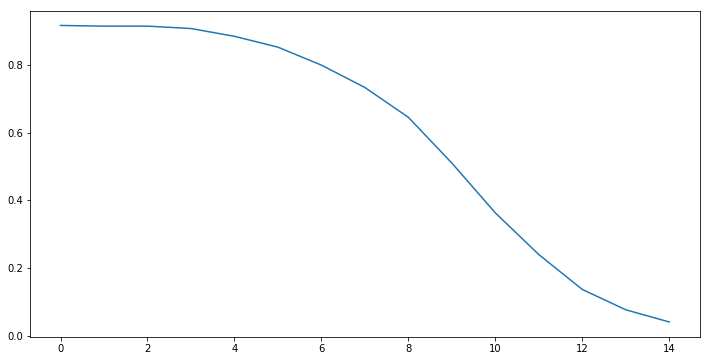

In [62]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 6)
axis_levels = ['{:.1f}'.format(0.8**(i+1)*100) for i in range(15)]
levels = list(range(15))
plt.plot(levels, scores_embedding, label='encoder.embedding')
plt.plot(levels, scores_intermediate, label='encoder.intermediate (dense)')
plt.plot(levels, scores_attn, label='encoder.attention (weight)')
plt.plot(levels, scores_out_dense, label='encoder.output (dense)')
plt.plot(levels, scores_dec_linear, label='decoder.linear (dense)')
plt.plot(levels, scores_dec_attn, label='decoder.attention (dense)')
# plt.xlim(.8,0)
# plt.ylim(0,1)
plt.ylabel('F1 (Test)')
plt.xlabel('Pct. params remaining')
plt.xticks(levels, axis_levels)
plt.legend()

In [95]:
result = validate_step(data.valid_dl, model, learner.data.id2label, learner.sup_labels)
print(result)

             precision    recall  f1-score   support

     B_MISC      0.565     0.778     0.654       688
      B_PER      0.703     0.762     0.731      1566
      I_PER      0.933     0.538     0.682      1134
      B_LOC      0.831     0.815     0.823      1570
      I_ORG      0.621     0.631     0.626       835
     I_MISC      0.272     0.613     0.377       222
      I_LOC      0.694     0.574     0.629       249

avg / total      0.735     0.706     0.706      6264



In [41]:
sens_embedding + sens_intermediate

['encoder.embeddings.model.embeddings.word_embeddings.weight',
 'encoder.embeddings.model.encoder.layer.0.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.1.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.2.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.3.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.4.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.5.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.6.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.7.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.8.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.9.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.10.intermediate.dense.weight',
 'encoder.embeddings.model.encoder.layer.11.intermediate.dense.weight']

In [48]:
#n. params org.
param_count(model)

179005021.0

In [46]:
#n. params pruned
param_count(model)

164849245.0

### Iterative pruning

In [193]:
sensitivity_cpt_path = '/home/ec2-user/datadrive/models/conll-2003/bilstm_attn_trained_for_sensitivity.cpt'
# model = BertBiLSTMAttnCRF.create(len(data.label2idx), bert_config_file, init_checkpoint_pt, enc_hidden_dim=256)
model.load_state_dict(torch.load(sensitivity_cpt_path))
torch.cuda.empty_cache()

In [52]:
# pruner = SparsityPruner(model, sens_enc)
# scores_iterative = []
n_ft_epochs = 5
for i in range(1,3):
    print('Retaining {:.1f}% params'.format(.8**(i+1)*100))
    pruner.prune(.5)
    learner.fit(n_ft_epochs, target_metric='f1', pruner=pruner)
    result = validate_step(data.valid_dl, model, learner.data.id2label, learner.sup_labels)
    f1 = parse_f1(result)
    scores_iterative.append(f1)
    print('{:.1f}% params, F1 after fine-tuning: {}'.format(.8**(i+1)*100,f1))

Retaining 64.0% params


2019-04-23 05:38:47,900 INFO: Resuming train... Current epoch 5.
2019-04-23 05:40:06,632 INFO: 
epoch 6, average train epoch loss=3.739

2019-04-23 05:40:19,583 INFO: on epoch 2 by max_f1: 0.958
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.906     0.860     0.882       905
      B_PER      0.939     0.897     0.917      1686
      I_PER      0.965     0.946     0.956      1170
      B_LOC      0.896     0.923     0.909      1669
      I_ORG      0.912     0.764     0.832       734
     I_MISC      0.820     0.778     0.799       352
      I_LOC      0.839     0.911     0.873       257

avg / total      0.916     0.887     0.900      6773



2019-04-23 05:41:40,042 INFO: 
epoch 7, average train epoch loss=1.219

2019-04-23 05:41:53,051 INFO: on epoch 2 by max_f1: 0.958
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.867     0.883     0.875       905
      B_PER      0.909     0.941     0.925      1686
      I_PER      0.947     0.970     0.958      1170
      B_LOC      0.892     0.932     0.912      1669
      I_ORG      0.887     0.827     0.856       734
     I_MISC      0.818     0.793     0.805       352
      I_LOC      0.913     0.856     0.884       257

avg / total      0.899     0.913     0.905      6773



2019-04-23 05:43:14,038 INFO: 
epoch 8, average train epoch loss=0.7766

2019-04-23 05:43:27,449 INFO: on epoch 2 by max_f1: 0.958
train loss: 0.01621246337890625:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.883     0.867     0.875       905
      B_PER      0.912     0.948     0.930      1686
      I_PER      0.942     0.974     0.958      1170
      B_LOC      0.937     0.912     0.924      1669
      I_ORG      0.904     0.832     0.867       734
     I_MISC      0.809     0.804     0.806       352
      I_LOC      0.922     0.833     0.875       257

avg / total      0.914     0.908     0.911      6773



2019-04-23 05:44:49,405 INFO: 
epoch 9, average train epoch loss=0.6319

2019-04-23 05:45:02,838 INFO: on epoch 2 by max_f1: 0.958
train loss: 0.0625762939453125:   0%|          | 1/436 [00:00<01:16,  5.65it/s]

             precision    recall  f1-score   support

     B_MISC      0.924     0.855     0.888       905
      B_PER      0.946     0.916     0.931      1686
      I_PER      0.973     0.958     0.966      1170
      B_LOC      0.907     0.937     0.922      1669
      I_ORG      0.874     0.869     0.872       734
     I_MISC      0.923     0.685     0.786       352
      I_LOC      0.909     0.860     0.884       257

avg / total      0.928     0.901     0.913      6773



2019-04-23 05:46:24,015 INFO: 
epoch 10, average train epoch loss=0.6072

2019-04-23 05:46:37,453 INFO: on epoch 2 by max_f1: 0.958
  0%|          | 0/98 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.937     0.821     0.875       905
      B_PER      0.926     0.957     0.941      1686
      I_PER      0.966     0.964     0.965      1170
      B_LOC      0.934     0.919     0.926      1669
      I_ORG      0.825     0.857     0.841       734
     I_MISC      0.866     0.756     0.807       352
      I_LOC      0.912     0.844     0.877       257

avg / total      0.922     0.905     0.912      6773



64.0% params, F1 after fine-tuning: 0.877
Retaining 51.2% params


2019-04-23 05:46:56,086 INFO: Resuming train... Current epoch 10.
2019-04-23 05:48:16,734 INFO: 
epoch 11, average train epoch loss=2.6684

2019-04-23 05:48:30,140 INFO: on epoch 2 by max_f1: 0.958
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.887     0.861     0.874       905
      B_PER      0.887     0.923     0.905      1686
      I_PER      0.946     0.946     0.946      1170
      B_LOC      0.918     0.905     0.912      1669
      I_ORG      0.801     0.842     0.821       734
     I_MISC      0.891     0.741     0.809       352
      I_LOC      0.856     0.833     0.844       257

avg / total      0.895     0.893     0.893      6773



2019-04-23 05:49:50,813 INFO: 
epoch 12, average train epoch loss=0.99777

2019-04-23 05:50:04,215 INFO: on epoch 2 by max_f1: 0.958
train loss: 0.3296375274658203:   0%|          | 2/436 [00:00<00:42, 10.18it/s]

             precision    recall  f1-score   support

     B_MISC      0.883     0.869     0.876       905
      B_PER      0.943     0.899     0.920      1686
      I_PER      0.959     0.950     0.955      1170
      B_LOC      0.909     0.929     0.919      1669
      I_ORG      0.891     0.826     0.857       734
     I_MISC      0.873     0.744     0.804       352
      I_LOC      0.890     0.852     0.871       257

avg / total      0.918     0.893     0.905      6773



2019-04-23 05:51:26,309 INFO: 
epoch 13, average train epoch loss=0.62316

2019-04-23 05:51:39,692 INFO: on epoch 2 by max_f1: 0.958
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.924     0.851     0.886       905
      B_PER      0.909     0.934     0.921      1686
      I_PER      0.960     0.960     0.960      1170
      B_LOC      0.897     0.930     0.913      1669
      I_ORG      0.860     0.849     0.855       734
     I_MISC      0.922     0.739     0.820       352
      I_LOC      0.835     0.907     0.869       257

avg / total      0.909     0.906     0.907      6773



2019-04-23 05:52:59,593 INFO: 
epoch 14, average train epoch loss=0.46001

2019-04-23 05:53:13,021 INFO: on epoch 2 by max_f1: 0.958
train loss: 0.06274795532226562:   0%|          | 1/436 [00:00<01:00,  7.20it/s]

             precision    recall  f1-score   support

     B_MISC      0.879     0.885     0.882       905
      B_PER      0.907     0.925     0.916      1686
      I_PER      0.971     0.938     0.954      1170
      B_LOC      0.928     0.918     0.923      1669
      I_ORG      0.911     0.779     0.840       734
     I_MISC      0.775     0.801     0.788       352
      I_LOC      0.923     0.837     0.878       257

avg / total      0.914     0.894     0.903      6773



2019-04-23 05:54:34,795 INFO: 
epoch 15, average train epoch loss=0.29998

2019-04-23 05:54:48,212 INFO: on epoch 2 by max_f1: 0.958
  0%|          | 0/98 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.869     0.866     0.868       905
      B_PER      0.921     0.936     0.928      1686
      I_PER      0.951     0.965     0.958      1170
      B_LOC      0.945     0.916     0.930      1669
      I_ORG      0.874     0.851     0.863       734
     I_MISC      0.857     0.767     0.810       352
      I_LOC      0.951     0.825     0.883       257

avg / total      0.918     0.904     0.911      6773



51.2% params, F1 after fine-tuning: 0.871


### 3. Create Learner

In [192]:
from modules import NerLearner

In [24]:
# Clear existing checkpoints
!ls /home/ec2-user/datadrive/models/conll-2003/

In [25]:
num_epochs = 100
learner = NerLearner(model, data,
                     best_model_path="/home/ec2-user/datadrive/models/conll-2003/bilstm_attn_cased.cpt",
                     lr=0.001, clip=1.0, sup_labels=data.id2label[5:],
                     t_total=num_epochs * len(data.train_dl))

### 4. Start learning

In [26]:
learner.fit(num_epochs, target_metric='f1')

2019-04-11 17:14:41,374 INFO: Resuming train... Current epoch 0.
2019-04-11 17:16:03,606 INFO: 
epoch 1, average train epoch loss=85.994

2019-04-11 17:16:16,883 INFO: on epoch 0 by max_f1: 0.004
2019-04-11 17:16:16,884 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.009     0.003     0.005       905
      B_PER      0.047     0.007     0.012      1686
      I_PER      0.000     0.000     0.000      1170
      B_LOC      0.000     0.000     0.000      1669
      I_ORG      0.000     0.000     0.000       734
     I_MISC      0.000     0.000     0.000       352
      I_LOC      0.000     0.000     0.000       257

avg / total      0.013     0.002     0.004      6773



2019-04-11 17:17:39,738 INFO: 
epoch 2, average train epoch loss=34.955

2019-04-11 17:17:52,887 INFO: on epoch 1 by max_f1: 0.254
2019-04-11 17:17:52,888 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.212     0.104     0.139       905
      B_PER      0.479     0.268     0.344      1686
      I_PER      0.384     0.349     0.365      1170
      B_LOC      0.328     0.267     0.294      1669
      I_ORG      0.722     0.071     0.129       734
     I_MISC      0.000     0.000     0.000       352
      I_LOC      0.000     0.000     0.000       257

avg / total      0.373     0.214     0.254      6773



2019-04-11 17:19:16,091 INFO: 
epoch 3, average train epoch loss=10.316

2019-04-11 17:19:29,740 INFO: on epoch 2 by max_f1: 0.797
2019-04-11 17:19:29,741 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.761     0.651     0.702       905
      B_PER      0.940     0.935     0.938      1686
      I_PER      0.917     0.957     0.936      1170
      B_LOC      0.816     0.890     0.851      1669
      I_ORG      0.706     0.632     0.667       734
     I_MISC      0.500     0.159     0.241       352
      I_LOC      0.514     0.276     0.359       257

avg / total      0.817     0.792     0.797      6773



2019-04-11 17:20:54,430 INFO: 
epoch 4, average train epoch loss=4.2734

2019-04-11 17:21:07,556 INFO: on epoch 3 by max_f1: 0.886
2019-04-11 17:21:07,557 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.815     0.767     0.790       905
      B_PER      0.969     0.954     0.961      1686
      I_PER      0.959     0.973     0.966      1170
      B_LOC      0.920     0.906     0.913      1669
      I_ORG      0.814     0.851     0.832       734
     I_MISC      0.763     0.511     0.612       352
      I_LOC      0.767     0.665     0.712       257

avg / total      0.899     0.875     0.886      6773



2019-04-11 17:22:32,456 INFO: 
epoch 5, average train epoch loss=2.7849

2019-04-11 17:22:46,109 INFO: on epoch 4 by max_f1: 0.917
2019-04-11 17:22:46,110 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.828     0.827     0.827       905
      B_PER      0.966     0.976     0.971      1686
      I_PER      0.979     0.975     0.977      1170
      B_LOC      0.951     0.905     0.927      1669
      I_ORG      0.920     0.864     0.891       734
     I_MISC      0.793     0.727     0.759       352
      I_LOC      0.814     0.868     0.840       257

avg / total      0.926     0.909     0.917      6773



2019-04-11 17:24:10,077 INFO: 
epoch 6, average train epoch loss=1.9921

2019-04-11 17:24:23,217 INFO: on epoch 5 by max_f1: 0.928
2019-04-11 17:24:23,218 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.835     0.886     0.860       905
      B_PER      0.972     0.973     0.972      1686
      I_PER      0.984     0.973     0.979      1170
      B_LOC      0.929     0.946     0.937      1669
      I_ORG      0.937     0.871     0.903       734
     I_MISC      0.855     0.719     0.781       352
      I_LOC      0.844     0.887     0.865       257

avg / total      0.930     0.927     0.928      6773



2019-04-11 17:25:47,359 INFO: 
epoch 7, average train epoch loss=1.5752

2019-04-11 17:26:01,021 INFO: on epoch 6 by max_f1: 0.937
2019-04-11 17:26:01,022 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.906     0.873     0.889       905
      B_PER      0.953     0.976     0.964      1686
      I_PER      0.984     0.977     0.981      1170
      B_LOC      0.960     0.941     0.950      1669
      I_ORG      0.939     0.875     0.906       734
     I_MISC      0.840     0.804     0.821       352
      I_LOC      0.879     0.907     0.893       257

avg / total      0.944     0.931     0.937      6773



2019-04-11 17:27:26,278 INFO: 
epoch 8, average train epoch loss=1.219

2019-04-11 17:27:39,700 INFO: on epoch 7 by max_f1: 0.945
2019-04-11 17:27:39,701 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.910     0.880     0.894       905
      B_PER      0.980     0.964     0.972      1686
      I_PER      0.984     0.981     0.982      1170
      B_LOC      0.953     0.952     0.952      1669
      I_ORG      0.957     0.910     0.933       734
     I_MISC      0.895     0.773     0.829       352
      I_LOC      0.905     0.926     0.915       257

avg / total      0.955     0.935     0.945      6773



2019-04-11 17:29:02,356 INFO: 
epoch 9, average train epoch loss=0.99128

2019-04-11 17:29:15,502 INFO: on epoch 7 by max_f1: 0.945
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.864     0.919     0.891       905
      B_PER      0.959     0.980     0.970      1686
      I_PER      0.985     0.979     0.982      1170
      B_LOC      0.957     0.949     0.953      1669
      I_ORG      0.934     0.905     0.919       734
     I_MISC      0.815     0.841     0.828       352
      I_LOC      0.915     0.879     0.897       257

avg / total      0.938     0.945     0.942      6773



2019-04-11 17:30:38,762 INFO: 
epoch 10, average train epoch loss=0.89813

2019-04-11 17:30:51,936 INFO: on epoch 7 by max_f1: 0.945
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.922     0.866     0.893       905
      B_PER      0.959     0.975     0.967      1686
      I_PER      0.987     0.976     0.982      1170
      B_LOC      0.952     0.942     0.947      1669
      I_ORG      0.936     0.921     0.929       734
     I_MISC      0.873     0.761     0.813       352
      I_LOC      0.928     0.907     0.917       257

avg / total      0.949     0.933     0.941      6773



2019-04-11 17:32:11,320 INFO: 
epoch 11, average train epoch loss=0.64953

2019-04-11 17:32:24,723 INFO: on epoch 7 by max_f1: 0.945
train loss: 0.1582646369934082:   0%|          | 1/436 [00:00<01:11,  6.12it/s]

             precision    recall  f1-score   support

     B_MISC      0.927     0.874     0.900       905
      B_PER      0.975     0.967     0.971      1686
      I_PER      0.987     0.979     0.983      1170
      B_LOC      0.948     0.956     0.952      1669
      I_ORG      0.914     0.955     0.934       734
     I_MISC      0.851     0.781     0.815       352
      I_LOC      0.907     0.911     0.909       257

avg / total      0.949     0.941     0.944      6773



2019-04-11 17:33:44,656 INFO: 
epoch 12, average train epoch loss=0.44599

2019-04-11 17:33:57,782 INFO: on epoch 11 by max_f1: 0.948
2019-04-11 17:33:57,783 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.899     0.903     0.901       905
      B_PER      0.973     0.976     0.975      1686
      I_PER      0.986     0.985     0.985      1170
      B_LOC      0.967     0.947     0.957      1669
      I_ORG      0.947     0.924     0.935       734
     I_MISC      0.833     0.824     0.829       352
      I_LOC      0.924     0.899     0.911       257

avg / total      0.952     0.944     0.948      6773



2019-04-11 17:35:23,239 INFO: 
epoch 13, average train epoch loss=0.37979

2019-04-11 17:35:36,512 INFO: on epoch 11 by max_f1: 0.948
train loss: 0.0262603759765625:   0%|          | 1/436 [00:00<00:43,  9.95it/s]

             precision    recall  f1-score   support

     B_MISC      0.902     0.895     0.899       905
      B_PER      0.952     0.982     0.966      1686
      I_PER      0.985     0.980     0.982      1170
      B_LOC      0.958     0.952     0.955      1669
      I_ORG      0.958     0.910     0.934       734
     I_MISC      0.816     0.847     0.831       352
      I_LOC      0.910     0.907     0.908       257

avg / total      0.944     0.945     0.944      6773



2019-04-11 17:36:55,517 INFO: 
epoch 14, average train epoch loss=0.29865

2019-04-11 17:37:08,715 INFO: on epoch 13 by max_f1: 0.95
2019-04-11 17:37:08,716 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.885     0.922     0.903       905
      B_PER      0.969     0.974     0.972      1686
      I_PER      0.993     0.984     0.988      1170
      B_LOC      0.970     0.944     0.957      1669
      I_ORG      0.956     0.926     0.941       734
     I_MISC      0.868     0.821     0.844       352
      I_LOC      0.901     0.918     0.909       257

avg / total      0.953     0.946     0.950      6773



2019-04-11 17:38:31,801 INFO: 
epoch 15, average train epoch loss=0.28335

2019-04-11 17:38:44,926 INFO: on epoch 13 by max_f1: 0.95
train loss: 0.007056236267089844:   0%|          | 1/436 [00:00<00:47,  9.19it/s]

             precision    recall  f1-score   support

     B_MISC      0.931     0.878     0.904       905
      B_PER      0.975     0.967     0.971      1686
      I_PER      0.994     0.972     0.983      1170
      B_LOC      0.944     0.959     0.952      1669
      I_ORG      0.925     0.936     0.930       734
     I_MISC      0.854     0.832     0.843       352
      I_LOC      0.951     0.907     0.928       257

avg / total      0.952     0.941     0.947      6773



2019-04-11 17:40:04,814 INFO: 
epoch 16, average train epoch loss=0.23126

2019-04-11 17:40:17,948 INFO: on epoch 13 by max_f1: 0.95
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.922     0.864     0.892       905
      B_PER      0.967     0.969     0.968      1686
      I_PER      0.982     0.985     0.983      1170
      B_LOC      0.939     0.969     0.954      1669
      I_ORG      0.949     0.931     0.939       734
     I_MISC      0.825     0.815     0.820       352
      I_LOC      0.914     0.914     0.914       257

avg / total      0.945     0.943     0.944      6773



2019-04-11 17:41:37,870 INFO: 
epoch 17, average train epoch loss=0.20831

2019-04-11 17:41:51,308 INFO: on epoch 13 by max_f1: 0.95
train loss: 0.06786823272705078:   0%|          | 1/436 [00:00<01:25,  5.10it/s]

             precision    recall  f1-score   support

     B_MISC      0.904     0.905     0.904       905
      B_PER      0.978     0.966     0.972      1686
      I_PER      0.986     0.981     0.984      1170
      B_LOC      0.965     0.948     0.956      1669
      I_ORG      0.920     0.956     0.938       734
     I_MISC      0.876     0.821     0.848       352
      I_LOC      0.947     0.899     0.922       257

avg / total      0.954     0.945     0.949      6773



2019-04-11 17:43:14,143 INFO: 
epoch 18, average train epoch loss=0.1497

2019-04-11 17:43:27,431 INFO: on epoch 13 by max_f1: 0.95
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.921     0.899     0.910       905
      B_PER      0.969     0.972     0.970      1686
      I_PER      0.990     0.981     0.985      1170
      B_LOC      0.953     0.962     0.957      1669
      I_ORG      0.943     0.931     0.937       734
     I_MISC      0.888     0.812     0.849       352
      I_LOC      0.933     0.914     0.923       257

avg / total      0.954     0.946     0.950      6773



2019-04-11 17:44:48,415 INFO: 
epoch 19, average train epoch loss=0.14791

2019-04-11 17:45:01,617 INFO: on epoch 13 by max_f1: 0.95
train loss: 0.15214157104492188:   0%|          | 1/436 [00:00<01:05,  6.65it/s]

             precision    recall  f1-score   support

     B_MISC      0.918     0.881     0.899       905
      B_PER      0.961     0.979     0.970      1686
      I_PER      0.985     0.986     0.985      1170
      B_LOC      0.955     0.962     0.958      1669
      I_ORG      0.941     0.932     0.936       734
     I_MISC      0.863     0.821     0.841       352
      I_LOC      0.935     0.895     0.915       257

avg / total      0.950     0.946     0.948      6773



2019-04-11 17:46:21,857 INFO: 
epoch 20, average train epoch loss=0.13318

2019-04-11 17:46:35,028 INFO: on epoch 19 by max_f1: 0.951
2019-04-11 17:46:35,028 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.904     0.905     0.904       905
      B_PER      0.966     0.982     0.974      1686
      I_PER      0.986     0.985     0.985      1170
      B_LOC      0.965     0.948     0.956      1669
      I_ORG      0.945     0.941     0.943       734
     I_MISC      0.891     0.838     0.864       352
      I_LOC      0.932     0.911     0.921       257

avg / total      0.954     0.949     0.951      6773



2019-04-11 17:47:58,653 INFO: 
epoch 21, average train epoch loss=0.12725

2019-04-11 17:48:11,848 INFO: on epoch 19 by max_f1: 0.951
train loss: 0.0006775856018066406:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.917     0.896     0.907       905
      B_PER      0.982     0.966     0.974      1686
      I_PER      0.991     0.975     0.983      1170
      B_LOC      0.960     0.947     0.953      1669
      I_ORG      0.945     0.936     0.940       734
     I_MISC      0.856     0.847     0.851       352
      I_LOC      0.958     0.895     0.926       257

avg / total      0.958     0.941     0.950      6773



2019-04-11 17:49:31,012 INFO: 
epoch 22, average train epoch loss=0.091524

2019-04-11 17:49:44,166 INFO: on epoch 21 by max_f1: 0.953
2019-04-11 17:49:44,167 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.916     0.901     0.908       905
      B_PER      0.971     0.976     0.973      1686
      I_PER      0.985     0.986     0.986      1170
      B_LOC      0.959     0.962     0.961      1669
      I_ORG      0.934     0.947     0.940       734
     I_MISC      0.888     0.832     0.859       352
      I_LOC      0.955     0.911     0.932       257

avg / total      0.954     0.951     0.953      6773



2019-04-11 17:51:07,953 INFO: 
epoch 23, average train epoch loss=0.10112

2019-04-11 17:51:21,221 INFO: on epoch 22 by max_f1: 0.954
2019-04-11 17:51:21,222 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.914     0.912     0.913       905
      B_PER      0.970     0.974     0.972      1686
      I_PER      0.991     0.985     0.988      1170
      B_LOC      0.967     0.959     0.963      1669
      I_ORG      0.946     0.939     0.943       734
     I_MISC      0.870     0.855     0.862       352
      I_LOC      0.959     0.914     0.936       257

avg / total      0.957     0.952     0.954      6773



2019-04-11 17:52:44,698 INFO: 
epoch 24, average train epoch loss=0.093198

2019-04-11 17:52:57,847 INFO: on epoch 22 by max_f1: 0.954
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.920     0.906     0.913       905
      B_PER      0.959     0.976     0.967      1686
      I_PER      0.991     0.983     0.987      1170
      B_LOC      0.954     0.962     0.958      1669
      I_ORG      0.957     0.939     0.948       734
     I_MISC      0.873     0.841     0.857       352
      I_LOC      0.951     0.907     0.928       257

avg / total      0.953     0.951     0.952      6773



2019-04-11 17:54:19,338 INFO: 
epoch 25, average train epoch loss=0.0956

2019-04-11 17:54:32,472 INFO: on epoch 22 by max_f1: 0.954
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.923     0.905     0.914       905
      B_PER      0.963     0.976     0.970      1686
      I_PER      0.991     0.974     0.983      1170
      B_LOC      0.969     0.954     0.961      1669
      I_ORG      0.963     0.917     0.939       734
     I_MISC      0.860     0.858     0.859       352
      I_LOC      0.955     0.914     0.934       257

avg / total      0.958     0.946     0.952      6773



2019-04-11 17:55:53,492 INFO: 
epoch 26, average train epoch loss=0.072702

2019-04-11 17:56:06,698 INFO: on epoch 22 by max_f1: 0.954
train loss: 0.00014019012451171875:   0%|          | 1/436 [00:00<00:47,  9.08it/s]

             precision    recall  f1-score   support

     B_MISC      0.891     0.914     0.902       905
      B_PER      0.977     0.970     0.974      1686
      I_PER      0.990     0.977     0.984      1170
      B_LOC      0.961     0.957     0.959      1669
      I_ORG      0.955     0.932     0.943       734
     I_MISC      0.837     0.861     0.849       352
      I_LOC      0.948     0.914     0.931       257

avg / total      0.953     0.949     0.951      6773



2019-04-11 17:57:25,286 INFO: 
epoch 27, average train epoch loss=0.073884

2019-04-11 17:57:38,471 INFO: on epoch 22 by max_f1: 0.954
train loss: 0.0002498626708984375:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.907     0.913     0.910       905
      B_PER      0.985     0.974     0.979      1686
      I_PER      0.995     0.981     0.988      1170
      B_LOC      0.967     0.959     0.963      1669
      I_ORG      0.947     0.928     0.937       734
     I_MISC      0.854     0.849     0.852       352
      I_LOC      0.933     0.922     0.928       257

avg / total      0.959     0.950     0.954      6773



2019-04-11 17:59:00,417 INFO: 
epoch 28, average train epoch loss=0.064472

2019-04-11 17:59:13,664 INFO: on epoch 22 by max_f1: 0.954
train loss: 0.017823219299316406:   0%|          | 1/436 [00:00<00:46,  9.35it/s]

             precision    recall  f1-score   support

     B_MISC      0.937     0.885     0.910       905
      B_PER      0.965     0.979     0.972      1686
      I_PER      0.985     0.987     0.986      1170
      B_LOC      0.962     0.958     0.960      1669
      I_ORG      0.938     0.933     0.936       734
     I_MISC      0.904     0.798     0.848       352
      I_LOC      0.918     0.914     0.916       257

avg / total      0.956     0.946     0.951      6773



2019-04-11 18:00:34,858 INFO: 
epoch 29, average train epoch loss=0.066459

2019-04-11 18:00:48,038 INFO: on epoch 22 by max_f1: 0.954
train loss: 0.00014257431030273438:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.902     0.916     0.909       905
      B_PER      0.965     0.982     0.974      1686
      I_PER      0.986     0.990     0.988      1170
      B_LOC      0.937     0.975     0.956      1669
      I_ORG      0.954     0.924     0.938       734
     I_MISC      0.856     0.844     0.850       352
      I_LOC      0.927     0.934     0.930       257

avg / total      0.945     0.958     0.951      6773



2019-04-11 18:02:08,608 INFO: 
epoch 30, average train epoch loss=0.053558

2019-04-11 18:02:22,180 INFO: on epoch 22 by max_f1: 0.954
train loss: 0.00015926361083984375:   0%|          | 1/436 [00:00<01:11,  6.05it/s]

             precision    recall  f1-score   support

     B_MISC      0.916     0.903     0.909       905
      B_PER      0.964     0.979     0.972      1686
      I_PER      0.986     0.985     0.986      1170
      B_LOC      0.969     0.950     0.959      1669
      I_ORG      0.940     0.936     0.938       734
     I_MISC      0.870     0.818     0.843       352
      I_LOC      0.936     0.914     0.925       257

avg / total      0.954     0.947     0.951      6773



2019-04-11 18:03:44,207 INFO: 
epoch 31, average train epoch loss=0.049797

2019-04-11 18:03:57,433 INFO: on epoch 30 by max_f1: 0.955
2019-04-11 18:03:57,434 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.930     0.904     0.917       905
      B_PER      0.973     0.977     0.975      1686
      I_PER      0.989     0.983     0.986      1170
      B_LOC      0.965     0.962     0.964      1669
      I_ORG      0.940     0.937     0.939       734
     I_MISC      0.911     0.818     0.862       352
      I_LOC      0.951     0.914     0.933       257

avg / total      0.960     0.950     0.955      6773



2019-04-11 18:05:19,150 INFO: 
epoch 32, average train epoch loss=0.044037

2019-04-11 18:05:32,387 INFO: on epoch 30 by max_f1: 0.955
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.935     0.895     0.915       905
      B_PER      0.959     0.980     0.969      1686
      I_PER      0.986     0.990     0.988      1170
      B_LOC      0.965     0.960     0.962      1669
      I_ORG      0.954     0.936     0.945       734
     I_MISC      0.887     0.824     0.854       352
      I_LOC      0.963     0.922     0.942       257

avg / total      0.958     0.950     0.954      6773



2019-04-11 18:06:52,667 INFO: 
epoch 33, average train epoch loss=0.037188

2019-04-11 18:07:06,085 INFO: on epoch 32 by max_f1: 0.957
2019-04-11 18:07:06,085 INFO: Saving new best model...


             precision    recall  f1-score   support

     B_MISC      0.926     0.915     0.921       905
      B_PER      0.965     0.984     0.974      1686
      I_PER      0.986     0.991     0.988      1170
      B_LOC      0.970     0.962     0.966      1669
      I_ORG      0.956     0.928     0.942       734
     I_MISC      0.885     0.872     0.878       352
      I_LOC      0.944     0.922     0.933       257

avg / total      0.959     0.956     0.957      6773



2019-04-11 18:08:30,753 INFO: 
epoch 34, average train epoch loss=0.057352

2019-04-11 18:08:43,867 INFO: on epoch 32 by max_f1: 0.957
train loss: 2.86102294921875e-06:   0%|          | 1/436 [00:00<00:54,  7.95it/s]

             precision    recall  f1-score   support

     B_MISC      0.929     0.902     0.915       905
      B_PER      0.971     0.977     0.974      1686
      I_PER      0.990     0.985     0.987      1170
      B_LOC      0.963     0.963     0.963      1669
      I_ORG      0.941     0.943     0.942       734
     I_MISC      0.887     0.844     0.865       352
      I_LOC      0.955     0.914     0.934       257

avg / total      0.959     0.952     0.955      6773



2019-04-11 18:10:06,655 INFO: 
epoch 35, average train epoch loss=0.037303

2019-04-11 18:10:20,312 INFO: on epoch 32 by max_f1: 0.957
train loss: 5.817413330078125e-05:   0%|          | 1/436 [00:00<01:00,  7.18it/s]

             precision    recall  f1-score   support

     B_MISC      0.918     0.906     0.912       905
      B_PER      0.983     0.970     0.976      1686
      I_PER      0.994     0.985     0.989      1170
      B_LOC      0.967     0.952     0.959      1669
      I_ORG      0.936     0.936     0.936       734
     I_MISC      0.894     0.835     0.863       352
      I_LOC      0.955     0.899     0.926       257

avg / total      0.961     0.946     0.954      6773



2019-04-11 18:11:40,142 INFO: 
epoch 36, average train epoch loss=0.035259

2019-04-11 18:11:53,295 INFO: on epoch 32 by max_f1: 0.957
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.921     0.909     0.915       905
      B_PER      0.976     0.977     0.977      1686
      I_PER      0.989     0.987     0.988      1170
      B_LOC      0.959     0.963     0.961      1669
      I_ORG      0.957     0.917     0.937       734
     I_MISC      0.892     0.841     0.865       352
      I_LOC      0.905     0.930     0.917       257

avg / total      0.957     0.951     0.954      6773



2019-04-11 18:13:13,402 INFO: 
epoch 37, average train epoch loss=0.038973

2019-04-11 18:13:26,623 INFO: on epoch 32 by max_f1: 0.957
train loss: 1.239776611328125e-05:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.932     0.902     0.916       905
      B_PER      0.969     0.975     0.972      1686
      I_PER      0.992     0.982     0.987      1170
      B_LOC      0.962     0.962     0.962      1669
      I_ORG      0.930     0.943     0.936       734
     I_MISC      0.879     0.824     0.850       352
      I_LOC      0.940     0.922     0.931       257

avg / total      0.956     0.950     0.953      6773



2019-04-11 18:14:46,083 INFO: 
epoch 38, average train epoch loss=0.033369

2019-04-11 18:14:59,252 INFO: on epoch 32 by max_f1: 0.957
train loss: 0.0004487037658691406:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.916     0.907     0.912       905
      B_PER      0.983     0.971     0.977      1686
      I_PER      0.992     0.983     0.988      1170
      B_LOC      0.966     0.959     0.962      1669
      I_ORG      0.936     0.939     0.937       734
     I_MISC      0.873     0.838     0.855       352
      I_LOC      0.918     0.914     0.916       257

avg / total      0.958     0.949     0.954      6773



2019-04-11 18:16:20,983 INFO: 
epoch 39, average train epoch loss=0.03044

2019-04-11 18:16:34,141 INFO: on epoch 32 by max_f1: 0.957
train loss: 0.00011348724365234375:   0%|          | 1/436 [00:00<00:55,  7.78it/s]

             precision    recall  f1-score   support

     B_MISC      0.922     0.906     0.914       905
      B_PER      0.982     0.973     0.977      1686
      I_PER      0.992     0.981     0.987      1170
      B_LOC      0.954     0.963     0.959      1669
      I_ORG      0.945     0.935     0.940       734
     I_MISC      0.892     0.824     0.857       352
      I_LOC      0.948     0.914     0.931       257

avg / total      0.959     0.949     0.954      6773



2019-04-11 18:17:55,225 INFO: 
epoch 40, average train epoch loss=0.035572

2019-04-11 18:18:08,418 INFO: on epoch 32 by max_f1: 0.957
train loss: 7.62939453125e-05:   0%|          | 1/436 [00:00<00:55,  7.87it/s]

             precision    recall  f1-score   support

     B_MISC      0.932     0.898     0.915       905
      B_PER      0.983     0.976     0.979      1686
      I_PER      0.991     0.988     0.990      1170
      B_LOC      0.954     0.960     0.957      1669
      I_ORG      0.943     0.929     0.936       734
     I_MISC      0.881     0.844     0.862       352
      I_LOC      0.922     0.922     0.922       257

avg / total      0.959     0.950     0.954      6773



2019-04-11 18:19:30,937 INFO: 
epoch 41, average train epoch loss=0.032861

2019-04-11 18:19:45,400 INFO: on epoch 32 by max_f1: 0.957
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.930     0.906     0.918       905
      B_PER      0.975     0.979     0.977      1686
      I_PER      0.994     0.982     0.988      1170
      B_LOC      0.967     0.959     0.963      1669
      I_ORG      0.945     0.929     0.937       734
     I_MISC      0.900     0.841     0.869       352
      I_LOC      0.940     0.911     0.925       257

avg / total      0.962     0.950     0.956      6773



2019-04-11 18:21:06,724 INFO: 
epoch 42, average train epoch loss=0.021528

2019-04-11 18:21:20,016 INFO: on epoch 32 by max_f1: 0.957
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.920     0.904     0.912       905
      B_PER      0.967     0.981     0.974      1686
      I_PER      0.992     0.979     0.986      1170
      B_LOC      0.968     0.955     0.961      1669
      I_ORG      0.947     0.940     0.943       734
     I_MISC      0.874     0.847     0.860       352
      I_LOC      0.955     0.907     0.930       257

avg / total      0.958     0.950     0.954      6773



2019-04-11 18:22:41,190 INFO: 
epoch 43, average train epoch loss=0.024263

2019-04-11 18:22:54,494 INFO: on epoch 32 by max_f1: 0.957
  0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.925     0.912     0.918       905
      B_PER      0.976     0.980     0.978      1686
      I_PER      0.991     0.985     0.988      1170
      B_LOC      0.965     0.960     0.963      1669
      I_ORG      0.952     0.937     0.944       734
     I_MISC      0.893     0.827     0.858       352
      I_LOC      0.943     0.899     0.920       257

avg / total      0.961     0.951     0.956      6773



2019-04-11 18:24:15,536 INFO: 
epoch 44, average train epoch loss=0.021751

2019-04-11 18:24:28,705 INFO: on epoch 32 by max_f1: 0.957
train loss: -0.0001239776611328125:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.926     0.909     0.918       905
      B_PER      0.977     0.979     0.978      1686
      I_PER      0.992     0.981     0.987      1170
      B_LOC      0.969     0.964     0.966      1669
      I_ORG      0.959     0.916     0.937       734
     I_MISC      0.881     0.844     0.862       352
      I_LOC      0.963     0.903     0.932       257

avg / total      0.963     0.950     0.956      6773



2019-04-11 18:25:50,297 INFO: 
epoch 45, average train epoch loss=0.0202

2019-04-11 18:26:03,483 INFO: on epoch 32 by max_f1: 0.957
train loss: 0.00019550323486328125:   0%|          | 1/436 [00:00<00:47,  9.20it/s]

             precision    recall  f1-score   support

     B_MISC      0.911     0.912     0.911       905
      B_PER      0.968     0.983     0.976      1686
      I_PER      0.988     0.984     0.986      1170
      B_LOC      0.968     0.961     0.965      1669
      I_ORG      0.949     0.941     0.945       734
     I_MISC      0.896     0.810     0.851       352
      I_LOC      0.963     0.911     0.936       257

avg / total      0.958     0.952     0.955      6773



2019-04-11 18:27:25,658 INFO: 
epoch 46, average train epoch loss=0.019677

2019-04-11 18:27:38,839 INFO: on epoch 32 by max_f1: 0.957
train loss: 0.00016689300537109375:   0%|          | 1/436 [00:00<00:48,  8.96it/s]

             precision    recall  f1-score   support

     B_MISC      0.932     0.893     0.912       905
      B_PER      0.976     0.979     0.978      1686
      I_PER      0.992     0.979     0.986      1170
      B_LOC      0.969     0.958     0.963      1669
      I_ORG      0.946     0.931     0.938       734
     I_MISC      0.882     0.827     0.853       352
      I_LOC      0.950     0.895     0.922       257

avg / total      0.962     0.946     0.954      6773



2019-04-11 18:29:01,619 INFO: 
epoch 47, average train epoch loss=0.015824

2019-04-11 18:29:14,788 INFO: on epoch 32 by max_f1: 0.957
train loss: 6.29425048828125e-05:   0%|          | 1/436 [00:00<00:48,  8.88it/s]

             precision    recall  f1-score   support

     B_MISC      0.927     0.912     0.919       905
      B_PER      0.976     0.978     0.977      1686
      I_PER      0.992     0.981     0.987      1170
      B_LOC      0.966     0.959     0.962      1669
      I_ORG      0.947     0.933     0.940       734
     I_MISC      0.887     0.824     0.854       352
      I_LOC      0.951     0.911     0.930       257

avg / total      0.961     0.950     0.955      6773



2019-04-11 18:30:37,019 INFO: 
epoch 48, average train epoch loss=0.062551

2019-04-11 18:30:50,592 INFO: on epoch 32 by max_f1: 0.957
train loss: -0.00014972686767578125:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.928     0.896     0.912       905
      B_PER      0.970     0.981     0.976      1686
      I_PER      0.991     0.979     0.985      1170
      B_LOC      0.968     0.957     0.963      1669
      I_ORG      0.952     0.926     0.939       734
     I_MISC      0.898     0.821     0.858       352
      I_LOC      0.943     0.899     0.920       257

avg / total      0.961     0.946     0.953      6773



2019-04-11 18:32:13,695 INFO: 
epoch 49, average train epoch loss=0.021023

2019-04-11 18:32:26,882 INFO: on epoch 32 by max_f1: 0.957
train loss: 0.0001239776611328125:   0%|          | 1/436 [00:00<01:11,  6.08it/s]

             precision    recall  f1-score   support

     B_MISC      0.926     0.903     0.914       905
      B_PER      0.978     0.976     0.977      1686
      I_PER      0.993     0.980     0.987      1170
      B_LOC      0.962     0.960     0.961      1669
      I_ORG      0.945     0.929     0.937       734
     I_MISC      0.885     0.830     0.856       352
      I_LOC      0.939     0.899     0.918       257

avg / total      0.960     0.947     0.953      6773



2019-04-11 18:33:47,474 INFO: 
epoch 50, average train epoch loss=0.0155

2019-04-11 18:34:00,712 INFO: on epoch 32 by max_f1: 0.957
train loss: 0.00012874603271484375:   0%|          | 0/436 [00:00<?, ?it/s]

             precision    recall  f1-score   support

     B_MISC      0.926     0.913     0.919       905
      B_PER      0.975     0.977     0.976      1686
      I_PER      0.991     0.981     0.986      1170
      B_LOC      0.964     0.960     0.962      1669
      I_ORG      0.945     0.929     0.937       734
     I_MISC      0.885     0.830     0.856       352
      I_LOC      0.915     0.918     0.917       257

avg / total      0.958     0.950     0.954      6773



train loss: 0.013126616176453351:  98%|█████████▊| 427/436 [01:15<00:01,  5.64it/s]

### 5. Evaluate dev set

In [47]:
from modules.data.bert_data import get_bert_data_loader_for_predict
dl = get_bert_data_loader_for_predict(data_path + "valid.csv", learner)

In [28]:
learner.load_model()

In [29]:
preds = learner.predict(dl)


100%|██████████| 109/109 [00:10<00:00, 15.83it/s]
                                                 

IOB precision

In [30]:
from modules.train.train import validate_step
print(validate_step(learner.data.valid_dl, learner.model, learner.data.id2label, learner.sup_labels))


100%|██████████| 109/109 [00:13<00:00, 11.31it/s]
                                                 

             precision    recall  f1-score   support

     B_MISC      0.926     0.915     0.921       905
      B_PER      0.965     0.984     0.974      1686
      I_PER      0.986     0.991     0.988      1170
      B_LOC      0.970     0.962     0.966      1669
      I_ORG      0.956     0.928     0.942       734
     I_MISC      0.885     0.872     0.878       352
      I_LOC      0.944     0.922     0.933       257

avg / total      0.959     0.956     0.957      6773



Span precision

In [31]:
from modules.utils.plot_metrics import get_bert_span_report
clf_report = get_bert_span_report(dl, preds, [])
print(clf_report)

             precision    recall  f1-score   support

        LOC      0.921     0.919     0.920      1669
          O      0.992     0.991     0.992     41821
        PER      0.942     0.964     0.953      1686
        ORG      0.841     0.844     0.843      1282
       MISC      0.880     0.890     0.885       905

avg / total      0.982     0.982     0.982     47363



### 6. Evaluate test set

In [32]:
from modules.data.bert_data import get_bert_data_loader_for_predict
dl = get_bert_data_loader_for_predict(data_path + "test.csv", learner)


 97%|█████████▋| 1513/1559 [00:01<00:00, 1310.34it/s]
                                                     

In [33]:
preds = learner.predict(dl)


 99%|█████████▉| 97/98 [00:11<00:00,  4.15it/s]
                                               

In [34]:
data = NerData.create(train_path, data_path + "test.csv", vocab_file)


 99%|█████████▊| 6885/6973 [00:05<00:00, 1326.59it/s]
                                                     
 96%|█████████▌| 1492/1559 [00:01<00:00, 1268.13it/s]
                                                     

IOB precision

In [291]:
from modules.train.train import validate_step
print(validate_step(data.valid_dl, model, learner.data.id2label, learner.sup_labels))


 99%|█████████▉| 97/98 [00:14<00:00,  3.38it/s]
                                               

             precision    recall  f1-score   support

     B_MISC      0.834     0.831     0.833       688
      B_PER      0.947     0.962     0.954      1566
      I_PER      0.979     0.994     0.986      1134
      B_LOC      0.916     0.929     0.922      1570
      I_ORG      0.868     0.892     0.880       835
     I_MISC      0.664     0.721     0.691       222
      I_LOC      0.841     0.871     0.856       249

avg / total      0.908     0.924     0.916      6264



Span precision

In [292]:
from modules.utils.plot_metrics import get_bert_span_report
clf_report = get_bert_span_report(dl, preds, [])
print(clf_report)

             precision    recall  f1-score   support

        LOC      0.846     0.862     0.854      1570
          O      0.981     0.977     0.979     37705
        PER      0.863     0.883     0.873      1566
        ORG      0.689     0.703     0.696      1533
       MISC      0.752     0.792     0.771       688

avg / total      0.957     0.957     0.957     43062



### 6a. Basic sensitivity analysis

In [46]:
param_sizes = {}
for name, param in model.named_parameters():
    param_sizes[name] = torch.norm(param.view(-1), p=0).item()

In [63]:
attn_total = 0.
int_total = 0.
total = 0.
for name, n_params in param_sizes.items():
    total += n_params
    if 'attention' in name:
        attn_total += n_params
    if 'intermediate' in name:
        int_total += n_params

total, attn_total, int_total

(179005021.0, 28514304.0, 28348416.0)

In [243]:
import matplotlib.pylab as plt
import numpy as np
import matplotlib.patches as mpatches
# plt.bar(param_sizes.keys(), param_sizes.values(), 1., color='g')

In [ ]:
param_sizes

In [165]:
encoder_keys = set(filter(lambda t: 'encoder' in t, param_sizes.keys()))
# group by parameter types
grouped_params = {}
for name in encoder_keys:
    # exclude bias, gamma, and beta terms
    if 'bias' in name or 'gamma' in name or 'beta' in name or 'decoder' in name:
        continue
    n_params = param_sizes[name]
    group = None
    if 'attention.self.query' in name:
        group = 'encoder.attention.self.query'
    elif 'attention.self.key' in name:
        group = 'encoder.attention.self.key'
    elif 'attention.self.value' in name:
        group = 'encoder.attention.self.value'
    elif 'attention.output' in name:
        group = 'encoder.attention.output'
    elif 'output' in name:
        group = 'encoder.output'
    elif 'intermediate' in name:
        group = 'encoder.intermediate'
    elif 'lstm' in name:
        group = 'encoder.lstm'
    
    if group is None:
        group = name.replace('encoder.', '')
        group = group.replace('embeddings.model.embeddings.','')
        group = 'encoder.' + group
    if group not in grouped_params:
        grouped_params[group] = n_params
    else:
        grouped_params[group] += n_params


In [166]:
grouped_list = list(grouped_params.items())
grouped_list = sorted(grouped_list, key=lambda t: -t[1])
grouped_params = dict(grouped_list)

In [167]:
grouped_params

{'encoder.word_embeddings.weight': 91812096.0,
 'encoder.intermediate': 28311552.0,
 'encoder.output': 28311552.0,
 'encoder.attention.self.value': 7077888.0,
 'encoder.attention.self.query': 7077888.0,
 'encoder.attention.output': 7077888.0,
 'encoder.attention.self.key': 7077888.0,
 'encoder.lstm': 917504.0,
 'encoder.embeddings.model.pooler.dense.weight': 589824.0,
 'encoder.position_embeddings.weight': 393216.0,
 'encoder.token_type_embeddings.weight': 1536.0,
 'encoder.embeddings.bert_weights': 12.0}

In [264]:
len(grouped_params.keys())
colors = [MPC,'r','xkcd:green','orange','orange','orange','orange','purple','purple','purple','purple','purple']


Text(0.5,1,'Parameter distribution (encoder)')

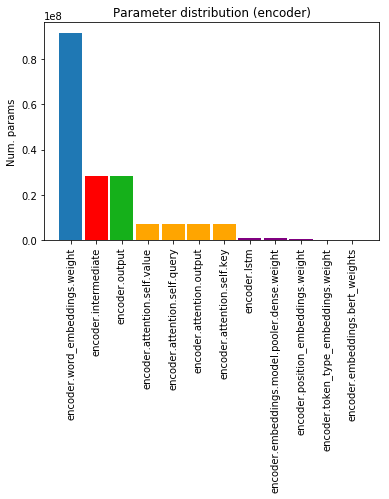

In [286]:
plt.bar(grouped_params.keys(), (list(grouped_params.values())), .9, color=colors)
plt.xticks(rotation=90)
plt.ylabel('Num. params')
plt.title('Parameter distribution (encoder)')

In [112]:
sum(grouped_params.values()) - grouped_params['intermediate']

77856768.0

In [185]:
decoder_keys = set(filter(lambda t: 'decoder' in t, param_sizes.keys()))
grouped_dec_params = {}

for name in decoder_keys:
    if 'bias' in name or 'gamma' in name or 'beta' in name or 'encoder' in name:
        continue
    n_params = param_sizes[name]
    group = None
    if 'attn' in name:
        group = 'decoder.attention'
    elif 'linear' in name:
        group = 'decoder.linear'

    if group is None:
        group = name
    if group not in grouped_dec_params:
        grouped_dec_params[group] = n_params
    else:
        grouped_dec_params[group] += n_params


In [186]:
grouped_dec_list = list(grouped_dec_params.items())
grouped_dec_list = sorted(grouped_dec_list, key=lambda t: -t[1])
grouped_dec_params = dict(grouped_dec_list)

Text(0.5,1,'Parameter distribution (decoder)')

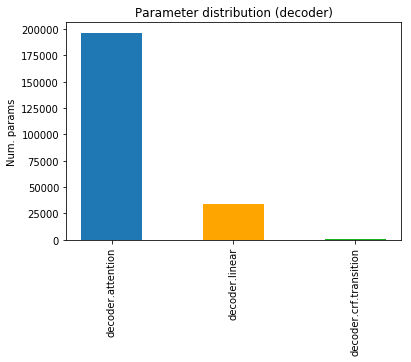

In [298]:
plt.bar(grouped_dec_params.keys(), (list(grouped_dec_params.values())), .5,color=[MPC,'orange','xkcd:green'])
plt.xticks(rotation=90)
plt.ylabel('Num. params')
plt.title('Parameter distribution (decoder)')

In [281]:
merged = {**grouped_params, **grouped_dec_params}
merge_list = list(merged.items())
merge_list = sorted(merge_list, key=lambda t: -t[1])
merged = dict(merge_list)

In [282]:
MPC = '#1F78B4'
colorlist = list(map(lambda k: MPC if 'encoder' in k else 'orange', merged.keys()))
leglist = list(map(lambda k: 'encoder' if 'encoder' in k else 'decoder', merged.keys()))

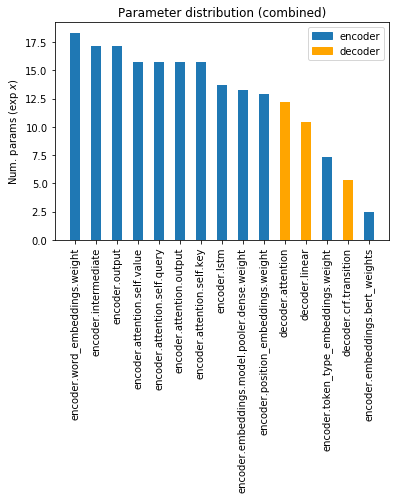

In [283]:
plt.bar(merged.keys(), np.log(list(merged.values())), .5, color=colorlist)

enc = mpatches.Patch(color=MPC, label='encoder')
dec = mpatches.Patch(color='orange', label='decoder')

plt.legend(handles=[enc,dec])
plt.xticks(rotation=90)
plt.ylabel('Num. params ($\exp \: x$)')
plt.title('Parameter distribution (combined)')
plt.show()

In [278]:
MPC = '#1F78B4'
colorlist = list(map(lambda k: 'orange' if 'attention' in k else MPC, merged.keys()))
leglist = list(map(lambda k: 'attention' if 'attention' in k else 'dense', merged.keys()))

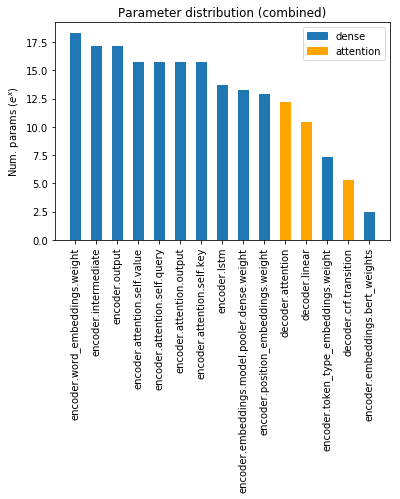

In [299]:
plt.bar(merged.keys(), np.log(list(merged.values())), .5, color=colorlist)

enc = mpatches.Patch(color=MPC, label='dense')
dec = mpatches.Patch(color='orange', label='attention')

plt.legend(handles=[enc,dec])
plt.xticks(rotation=90)
plt.ylabel('Num. params ($e^x$)')
plt.title('Parameter distribution (combined)')
plt.show()

In [290]:
#torch.save(model.state_dict(), open('/home/ec2-user/datadrive/models/conll-2003/bilstm_attn_trained_for_sensitivity.cpt', 'wb'))

### 7. Get mean and stdv on 10 runs

In [ ]:
from modules.utils.plot_metrics import *
from modules import NerLearner


num_runs = 10
best_reports = []
num_epochs = 100
for i in range(num_runs):
    model = BertBiLSTMAttnCRF.create(len(data.label2idx), bert_config_file, init_checkpoint_pt, enc_hidden_dim=256)
    best_model_path = "/home/ec2-user/datadrive/models/conll-2003/exp_{}_attn_cased.cpt".format(i)
    learner = NerLearner(model, data,
                         best_model_path=best_model_path, verbose=False,
                         lr=0.001, clip=5.0, sup_labels=data.id2label[5:], t_total=num_epochs * len(data.train_dl))
    learner.fit(num_epochs, target_metric='f1')
    idx, res = get_mean_max_metric(learner.history, "f1", True)
    best_reports.append(learner.history[idx])

In [17]:
import numpy as np

#### f1

Mean and std

In [18]:
np.mean([get_mean_max_metric([r]) for r in best_reports]), np.round(np.std([get_mean_max_metric([r]) for r in best_reports]), 3)

(0.949, 0.002)

Best

In [19]:
get_mean_max_metric(best_reports)

0.951

#### precision

Mean and std

In [20]:
np.mean([get_mean_max_metric([r], "prec") for r in best_reports]), np.round(np.std([get_mean_max_metric([r], "prec") for r in best_reports]), 3)

(0.9558333333333332, 0.002)

Best

In [21]:
get_mean_max_metric(best_reports, "prec")

0.959

#### Test set

In [24]:
idx = np.array([get_mean_max_metric([r]) for r in best_reports]).argmax()

In [25]:
learner.load_model("/datadrive/models/conll-2003/exp_{}_attn_cased.cpt".format(idx))

In [27]:
from modules.data.bert_data import get_bert_data_loader_for_predict
dl = get_bert_data_loader_for_predict(data_path + "test.csv", learner)

In [37]:
from modules.train.train import validate_step
print(validate_step(dl, learner.model, learner.data.id2label, learner.sup_labels))

              precision    recall  f1-score   support

         I_O      0.968     0.972     0.970     10257
      B_MISC      0.873     0.817     0.844       688
       B_PER      0.961     0.963     0.962      1566
       I_PER      0.970     0.971     0.970      3347
       B_LOC      0.932     0.926     0.929      1570
       I_LOC      0.904     0.870     0.887      1444
       I_ORG      0.888     0.922     0.905      2546
      I_MISC      0.746     0.611     0.672       839

   micro avg      0.942     0.937     0.940     22257
   macro avg      0.905     0.882     0.892     22257
weighted avg      0.941     0.937     0.939     22257



In [293]:
def contains(key, arr):
    for v in arr:
        if key in v:
            return True
    return False

In [297]:
contains('barz',['embedding.model.foo.bar'])

False